In [1]:
pip install ucimlrepo

Note: you may need to restart the kernel to use updated packages.


In [2]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
car_evaluation = fetch_ucirepo(id=19) 
  
# data (as pandas dataframes) 
X = car_evaluation.data.features 
y = car_evaluation.data.targets 
  
# metadata 
print(car_evaluation.metadata) 
  
# variable information 
print(car_evaluation.variables) 


{'uci_id': 19, 'name': 'Car Evaluation', 'repository_url': 'https://archive.ics.uci.edu/dataset/19/car+evaluation', 'data_url': 'https://archive.ics.uci.edu/static/public/19/data.csv', 'abstract': 'Derived from simple hierarchical decision model, this database may be useful for testing constructive induction and structure discovery methods.', 'area': 'Other', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 1728, 'num_features': 6, 'feature_types': ['Categorical'], 'demographics': [], 'target_col': ['class'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 1988, 'last_updated': 'Thu Aug 10 2023', 'dataset_doi': '10.24432/C5JP48', 'creators': ['Marko Bohanec'], 'intro_paper': {'title': 'Knowledge acquisition and explanation for multi-attribute decision making', 'authors': 'M. Bohanec, V. Rajkovič', 'published_in': '8th Intl Workshop on Expert Systems and their Applications, Avignon, France', 'yea

In [3]:
import pandas as pd

In [4]:
X.head()

,buying,maint,doors,persons,lug_boot,safety
0,vhigh,vhigh,2,2,small,low
1,vhigh,vhigh,2,2,small,med
2,vhigh,vhigh,2,2,small,high
3,vhigh,vhigh,2,2,med,low
4,vhigh,vhigh,2,2,med,med


In [5]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
ohe = OneHotEncoder(sparse=False)

In [6]:
column_trans = make_column_transformer(
    (OneHotEncoder(), ['buying','maint', 'doors','persons','lug_boot','safety']),
    sparse_threshold=0
)

In [7]:
X1 = column_trans.fit_transform(X)

In [8]:
pd.DataFrame(X1).head()

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


In [9]:
y.replace(to_replace=['unacc', 'acc','good','vgood'], value=[1, 2, 3, 4], inplace=True)

/var/folders/6f/7997wzgs63jg5ks497bchdq00000gp/T/ipykernel_99594/489436109.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y.replace(to_replace=['unacc', 'acc','good','vgood'], value=[1, 2, 3, 4], inplace=True)


In [10]:
y['class'].head()

0    1
1    1
2    1
3    1
4    1
Name: class, dtype: int64

In [11]:
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

In [12]:
logreg = LogisticRegression()

In [13]:
logistic_regression_pipeline = make_pipeline(column_trans, logreg)

In [14]:
X.head()

,buying,maint,doors,persons,lug_boot,safety
0,vhigh,vhigh,2,2,small,low
1,vhigh,vhigh,2,2,small,med
2,vhigh,vhigh,2,2,small,high
3,vhigh,vhigh,2,2,med,low
4,vhigh,vhigh,2,2,med,med


In [15]:
y.head()

,class
0,1
1,1
2,1
3,1
4,1


In [16]:
cross_val_score(logistic_regression_pipeline, X, y, cv=10, scoring='accuracy').mean()

/Users/asmohammed/opt/anaconda3/envs/KDM-ML/lib/python3.9/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/asmohammed/opt/anaconda3/envs/KDM-ML/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/asmohammed/opt/anaconda3/envs/KDM-ML/lib/python3.9/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when

0.8333075682215352

In [17]:
# try K=1 through K=25 and record testing accuracy
cv_range = list(range(4, 25))
scores = []
for i in cv_range:
    scores.append(cross_val_score(logistic_regression_pipeline, X, y, cv=i, scoring='accuracy').mean())

/Users/asmohammed/opt/anaconda3/envs/KDM-ML/lib/python3.9/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/asmohammed/opt/anaconda3/envs/KDM-ML/lib/python3.9/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/asmohammed/opt/anaconda3/envs/KDM-ML/lib/python3.9/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/asmohammed/opt/anaconda3/envs/KDM-ML/lib/python3.9/site-packages/sklearn/utils/validation.py:1143: DataConve

Text(0, 0.5, 'scores')

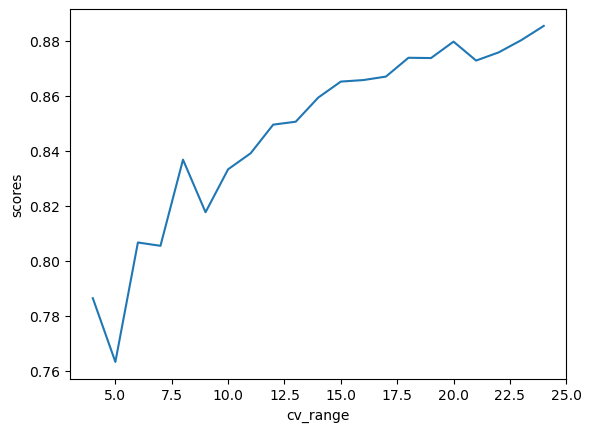

In [18]:
# import Matplotlib (scientific plotting library)
import matplotlib.pyplot as plt

# allow plots to appear within the notebook
%matplotlib inline

# plot the relationship between K and testing accuracy
plt.plot(cv_range, scores)
plt.xlabel('cv_range')
plt.ylabel('scores')

In [19]:
# try K=1 through K=25 and record testing accuracy
k_range = list(range(1, 26))
scores = []
from sklearn.neighbors import KNeighborsClassifier
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn_pipeline = make_pipeline(column_trans, knn)
    scores.append(cross_val_score(knn_pipeline, X, y, cv=10, scoring='accuracy').mean())

/Users/asmohammed/opt/anaconda3/envs/KDM-ML/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/Users/asmohammed/opt/anaconda3/envs/KDM-ML/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/Users/asmohammed/opt/anaconda3/envs/KDM-ML/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/Users/asmohammed/opt/anaconda3/envs/KDM-ML/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:215: Data

Text(0, 0.5, 'scores')

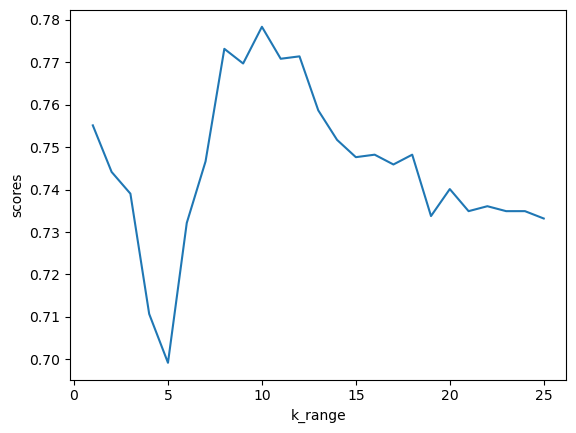

In [20]:
plt.plot(k_range, scores)
plt.xlabel('k_range')
plt.ylabel('scores')

In [21]:

pip install pydot onnx onnxruntime skl2onnx onnx-tool

Note: you may need to restart the kernel to use updated packages.


In [22]:
logistic_regression_pipeline.fit(X,y)

/Users/asmohammed/opt/anaconda3/envs/KDM-ML/lib/python3.9/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(sparse_threshold=0,
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(),
                                                  ['buying', 'maint', 'doors',
                                                   'persons', 'lug_boot',
                                                   'safety'])])),
                ('logisticregression', LogisticRegression())])

In [23]:
import pprint 
from numpy.testing import assert_almost_equal
import onnx
from onnx.tools.net_drawer import GetPydotGraph, GetOpNodeProducer 
import onnxruntime as rt
import skl2onnx
from skl2onnx import convert_sklearn
from skl2onnx.common.data_types import FloatTensorType, StringTensorType
from skl2onnx.common.data_types import Int64TensorType

In [24]:
def convert_dataframe_schema(df, drop=None):
    inputs = []
    for k, v in zip(df.columns, df.dtypes):
        if drop is not None and k in drop:
            continue
        if v == "int64":
            t = Int64TensorType([None, 1])
        elif v == "float64":
            t = FloatTensorType([None, 1])
        else:
            t = StringTensorType([None, 1])
        inputs.append((k, t))
    return inputs


initial_inputs = convert_dataframe_schema(X)

pprint.pprint(initial_inputs)

[('buying', StringTensorType(shape=[None, 1])),
 ('maint', StringTensorType(shape=[None, 1])),
 ('doors', StringTensorType(shape=[None, 1])),
 ('persons', StringTensorType(shape=[None, 1])),
 ('lug_boot', StringTensorType(shape=[None, 1])),
 ('safety', StringTensorType(shape=[None, 1]))]


In [25]:
#Convert the pipeline to ONNX
try:
    model_onnx = convert_sklearn(
        logistic_regression_pipeline, "logistic_regression_pipeline", initial_inputs
    )
    # And save.
    with open("pipeline_car_eval.onnx", "wb") as f:
        f.write(model_onnx.SerializeToString())
except Exception as e:
    print(e)